In [1]:
import pandas as pd

imputedDataset = pd.read_stata("/Users/burke/Documents/research/bpCog/mcm/mcm/data/fullyImputedDataset.dta")

In [46]:
import statsmodels.api as sm

imputedDataset = imputedDataset.rename({'selfReportMI' : 'mi', 
                                        'selfReportStroke' : 'stroke', 
                                        'tot_chol' : 'totChol',
                                        'meanDBP' : 'meanDbp',
                                        'meanSBP' : 'meanSbp'}, axis='columns')

imputedDataset['anyDeath'] = imputedDataset.ucod >= 1
#imputedDataset.monthsToDeath.loc[imputedDataset.anyDeath==0] = np.nan

sf1 = sm.duration.SurvfuncRight(imputedDataset.monthsToDeath, imputedDataset.anyDeath)
sf1.summary().head()

,Surv prob,Surv prob SE,num at risk,num events
Time,,,,
5.397605e-79,0.999767,0.000067,51397,12.0
1.000000e+00,0.999493,0.000099,51163,14.0
2.000000e+00,0.998726,0.000158,50830,39.0
3.000000e+00,0.998147,0.000191,50006,29.0
4.000000e+00,0.997520,0.000222,49336,31.0


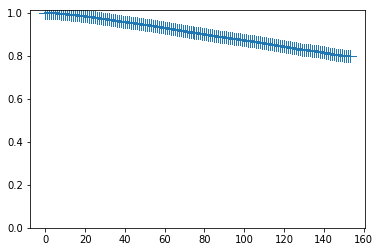

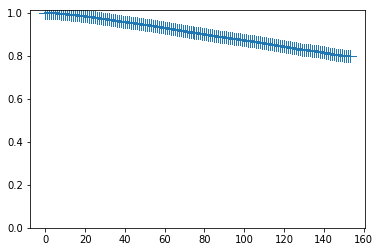

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

sf1.plot()

In [47]:
model = sm.PHReg.from_formula("monthsToDeath ~  age + a1c + bmi + gender + hdl + ldl + mi + stroke + totChol + trig + meanSbp + meanDbp + raceEthnicity + smokingStatus", status="anyDeath", data=imputedDataset)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                             Results: PHReg
========================================================================
Model:                      PH Reg              Sample size:       51397
Dependent variable:         monthsToDeath       Num. events:       3640 
Ties:                       Breslow                                     
------------------------------------------------------------------------
                    log HR log HR SE   HR      t    P>|t|  [0.025 0.975]
------------------------------------------------------------------------
raceEthnicity[T.2] -0.1008    0.1005 0.9041 -1.0032 0.3158 0.7425 1.1009
raceEthnicity[T.3]  0.1925    0.0502 1.2123  3.8351 0.0001 1.0987 1.3376
raceEthnicity[T.4]  0.2946    0.0595 1.3426  4.9523 0.0000 1.1948 1.5086
raceEthnicity[T.5] -0.1302    0.1163 0.8779 -1.1190 0.2631 0.6989 1.1028
smokingStatus[T.1]  0.1869    0.0385 1.2055  4.8510 0.0000 1.1178 1.3000
smokingStatus[T.2]  0.7442    0.0489 2.1049 15.2147 0.0000 1.9124 2.3167
age                 0.0822    0.0016 1.0857 50.3549 0.0000 1.0823 1.0892
a1c                 0.0992    0.0137 1.1043  7.2537 0.0000 1.0751 1.1343
bmi                -0.0158    0.0033 0.9843 -4.8261 0.0000 0.9780 0.9907
gender             -0.2502    0.0377 0.7786 -6.6380 0.0000 0.7232 0.8383
hdl                -0.0010    0.0016 0.9990 -0.6405 0.5218 0.9959 1.0021
ldl                -0.0005    0.0015 0.9995 -0.3300 0.7414 0.9965 1.0025
mi                  0.4022    0.0486 1.4951  8.2784 0.0000 1.3593 1.6445
stroke              0.4993    0.0503 1.6476  9.9347 0.0000 1.4931 1.8182
totChol            -0.0007    0.0015 0.9993 -0.4593 0.6460 0.9965 1.0022
trig                0.0002    0.0002 1.0002  1.3881 0.1651 0.9999 1.0005
meanSbp             0.0057    0.0008 1.0057  7.4768 0.0000 1.0042 1.0073
meanDbp            -0.0050    0.0010 0.9950 -4.9529 0.0000 0.9930 0.9970
========================================================================
Confidence intervals are for the hazard ratios
"""

In [27]:
imputedDataset.columns

Index(['index', 'WTINT2YR', 'a1c', 'age', 'bmi', 'diedBy2011', 'gender', 'hdl',
       'ldl', 'monthsToDeath', 'monthsToDeath2', 'selfReportMI',
       'selfReportMIAge', 'selfReportStroke', 'selfReportStrokeAge',
       'timeInUS', 'tot_chol', 'trig', 'ucod', 'weight', 'year', 'meanSBP',
       'meanDBP', 'raceEthnicity', 'smokingStatus', 'anyDeath'],
      dtype='object')

In [36]:
# get the baseline cumulative hazard at one year.
tuples = model.baseline_cumulative_hazard([0] * 18)
oneYearCumHazard = tuples[0][1][12]

In [37]:
oneYearCumHazard

0.008245026000825028

In [48]:
import sys
import os
sys.path.append(os.path.abspath("../mcm/"))
from mcm.cox_regression_model import CoxRegressionModel


coxModel = CoxRegressionModel(dict(zip(results.model.exog_names, results.params)),
                              dict(zip(results.model.exog_names, results.standard_errors)), 
                              oneYearCumHazard, 0)

coxModel.write_json(os.path.abspath("../mcm/mcm/data/nhanesMortalityModelSpec.json"))



In [10]:
test = model.predict(results.params)

In [11]:
test.predicted_values

array([1.95740109, 3.58564639, 1.73575721, ..., 3.39585851, 1.95145865,
       3.42881329])

In [15]:
len(test.predicted_values)

51397

In [20]:
imputedDataset.head(1)

,index,WTINT2YR,a1c,age,bmi,diedBy2011,gender,hdl,ldl,monthsToDeath,...,tot_chol,trig,ucod,weight,year,meanSBP,meanDBP,raceEthnicity,smokingStatus,anyDeath
0,0,102641.406474,5.1,22.0,23.3,0,1.0,41.0,110.0,7.0,...,168.0,84.0,0,69.2,2011,110.666667,74.666667,3,0,False
